In [1]:
pip install cirq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.7/532.7 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [18]:
import cirq
import numpy as np

def create_quantum_circuit(data):
  qubits = [cirq.GridQubit(i,0) for i in range(len(data))]
  circuit =cirq.Circuit()

  for i, value in enumerate(data):
    circuit.append(cirq.rx(value).on(qubits[i]))

  circuit.append(cirq.measure(*qubits,key='QSVM-Results'))
  return circuit, qubits

def run_quantum_circuit(circuit,qubits,repetitions=10**2):
  sim = cirq.Simulator()
  r = sim.run(circuit,repetitions=repetitions)
  m = np.array(r.measurements['QSVM-Results'])
  return m

def quantum_kernel(x):
  n_samples = x.shape[0]
  kernel_matrix = np.zeros((n_samples,n_samples))

  for i in range(n_samples):
    for j in range(n_samples):
       circuit, qubits = create_quantum_circuit(x[i]-x[j])
       m = run_quantum_circuit(circuit, qubits)
       kernel_matrix[i,j] = np.mean(m)

  return kernel_matrix

In [45]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

x,y = make_classification(n_samples=20, n_features=4, n_informative=2, n_classes=2, random_state=42)
scale = StandardScaler()
x = scale.fit_transform(x)

quantum_kernel_matrix = quantum_kernel(x)

In [46]:
model = SVC(kernel='linear') #precomputed
model.fit(quantum_kernel_matrix,y)
y_pred = model.predict(quantum_kernel_matrix)

In [47]:
print('Actual',y)
print('predicted',y_pred)

Actual [0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0]
predicted [0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0 0]


              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.80      0.80      0.80        10

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



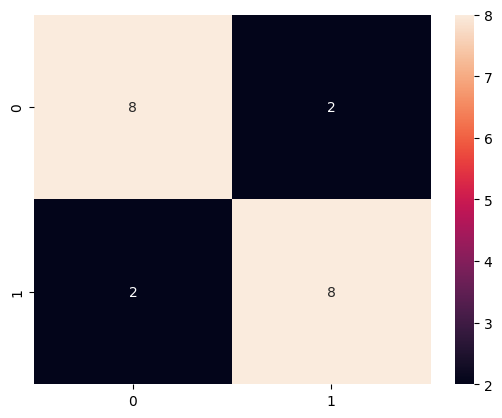

In [48]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

sns.heatmap(confusion_matrix(y,y_pred),annot=True)
print(classification_report(y,y_pred))